# SageMaker Processing Jobs - OpenGL Synthetic data generation
## NoGPU + Git

**SageMaker Studio Kernel: Data Science**

In this exercise you'll learn how to create a custom Docker container capable of running OpenGL applications that require an X Server to render images. Then, using this container you'll be able to run an OpenGL application and export each frame to a new image. To save space and reduce the number of images to upload to S3 later, we'll create mosaics of .jpeg files that can later be loaded by your ML training code.


This sample is similar to [this one](02_GenerateSyntheticDataWithOpenGLCPU.ipynb) but the files are kept in a GitRepo. So, you can push the processing files to a given repo and keep them decoupled from the processing job.

### 0) Install some dependencies

In [ ]:
!apt update -y && apt install -y libgl1
%pip install opencv-python

### 1) Build a custom docker container

Please, run [this notebook](02_GenerateSyntheticDataWithOpenGLCPU.ipynb) before to build the Docker image that will be used here.

### 2) Create a Processor object
We'll use FrameworkProcessor, which is a special type of processor that accepts a **Git** repo as parameter. This repo will be cloned into the processing container and the entrypoint can reference a script that was previously pushed to that repo.

In [ ]:
import time
import boto3
import sagemaker
import sagemaker.pytorch
from sagemaker.processing import ProcessingInput, ProcessingOutput

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = sagemaker_session.boto_session.region_name
bucket = sagemaker_session.default_bucket()

# Use the image generated for CPU in the Notebook 1
image_name='sm-processing-opengl-cpu'

print(f"Bucket: {bucket}\nAWS AccountID: {account_id}\nRegion: {region_name}")

In [ ]:
processing = sagemaker.processing.FrameworkProcessor(
    base_job_name=f'cube-cpu-git-{int(time.time()*1000)}',
    image_uri=f'{account_id}.dkr.ecr.{region_name}.amazonaws.com/{image_name}:latest',
    instance_type="ml.c5.xlarge",
    instance_count=1,    
    role=role,
    max_runtime_in_seconds=60 * 30,
    command=["/entrypoint.sh", "python3"],
    
    # dummy params only to make FrameworkProcessor happy. Will not be used
    estimator_cls=sagemaker.pytorch.PyTorch,
    framework_version='1.7'
)

### 3) Kick-off the processing job

In [ ]:
# Specifies the git_config parameter. This example does not provide Git credentials, so python SDK will try
# to use local credential storage.
git_config = {'repo': 'https://github.com/samir-souza/laboratory.git',
              'branch': 'master',
              #'commit': '903bc9811e8dbf7f82fbdd780b6ca7c6bfb2fe09'
             }

processing.run(
    code='13_SageMakerProcessingJobs/src/cube.py',
    git_config=git_config,
    outputs=[
        ProcessingOutput(
            output_name='gen_images', 
            s3_upload_mode='Continuous', 
            destination=f"s3://{bucket}/cube-opengl-cpu/images",
            source='/opt/ml/processing/output'
        )
    ],
    arguments=[ #total of images = num-mosaics * (mosaic-tiles ** 2)
        '--num-mosaics', '100',
        '--mosaic-tiles', '20',
        '--image-size', '400'
    ]
)

### 4) Visualize a mosaic

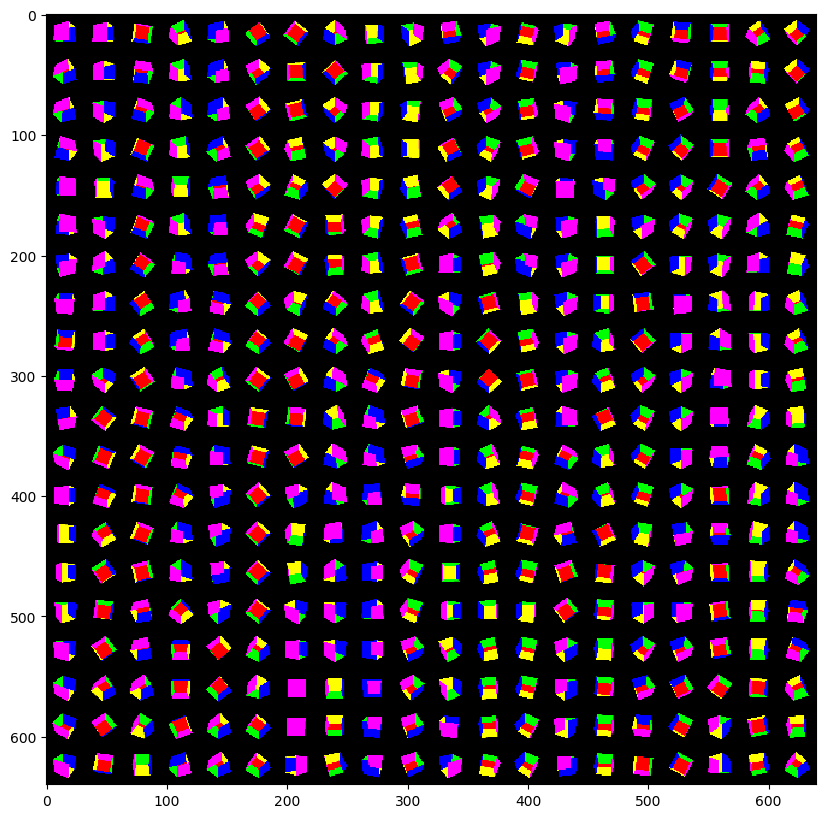

In [13]:
%matplotlib inline
import cv2
import boto3
import numpy as np
import matplotlib.pyplot as plt

s3_client = boto3.client('s3')
num_mosaic=5
data = s3_client.get_object(Bucket=bucket, Key=f"cube-opengl-cpu/images/mosaic_{num_mosaic:015d}.png")['Body'].read()
img = cv2.imdecode(np.frombuffer(data, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (640,640))
plt.figure(figsize=(10,10))
plt.imshow(img)